In [1]:
COUNT_NUMBERS_IN_STRINGS = 10
COUNT_STRINGS = 10

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
## Сгенерировать набор текстовых строк из допустимых символов.

In [5]:
import os
import random

directory = 'data'
symbols = list(map(lambda x: x.replace('times', '*'), [symb for symb in os.listdir(directory)]))
strings = [''.join(random.choices(symbols, k = COUNT_NUMBERS_IN_STRINGS)) for _ in range(COUNT_STRINGS)]

print(f'Возможные символы: {symbols}\nСтроки: {strings}')

Возможные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']
Строки: [',-4673-0h-', 'h5-2yX*4y3', '-(0y-,19X4', '720w(05X55', '796+*36y39', '1(8(80(6+w', '8t3111*w*5', '4*0y6t4X*8', '83t,-(-)65', ')5y(069h8(']


## Каждому набору поставить в соотвествие массив изоражений соответствующих символов.

In [6]:
from PIL import Image

def combine_images(images, min_scale=0.8, max_scale=0.9, max_offset=50, spacing=10):
    scaled_images = [
        Image.open(img).resize(
            (int(Image.open(img).width * scale), int(Image.open(img).height * scale)),
            Image.LANCZOS
        ) 
        for img, scale in zip(images, [random.uniform(min_scale, max_scale) for _ in images])
    ]

    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        combined_image.paste(img, (x_offset, random.randint(0, max_offset)))
        x_offset += img.width + spacing

    return combined_image

In [7]:
def get_symb_images_paths_map():
    symb_images = {}
    for symb in symbols:
        folder = directory + '/' + (symb if symb != '*' else 'times')
        symb_images[symb] = [folder + '/' + img_path for img_path in os.listdir(folder)] 
    return symb_images

In [8]:
def get_string_images_paths_map(symb_images):
    return {string : [symb_images[symbol][random.randint(0, len(symb_images[symbol]) - 1)] for symbol in string] for string in strings}

In [9]:
from glob import glob

symb_images = get_symb_images_paths_map()
strings_images = get_string_images_paths_map(symb_images)

my_images_directory = 'images'
[os.remove(file) for file in glob(f'{my_images_directory}/*')] # удаляем файлы, если они есть

my_images_paths = {}

for i, (string, images) in enumerate(strings_images.items(), start=1):
    new_image = combine_images(images)
    path = f'{my_images_directory}/{i}.png'
    new_image.save(path)
    my_images_paths[string] = path

# КЛАССИФИКАЦИЯ (k ближайших соседей)
## Часть символов оставить для обучения классификатора . Остальные  классифицировать по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.

In [10]:
import cv2
import numpy as np

def get_cv_image(image):
    # если дан путь к изображению
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # если дано изобажение PIL
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (28, 28)).flatten()
    
    return None

In [68]:
from concurrent.futures import ThreadPoolExecutor

def prepare_data(data_dict):
    X = []
    y = []
    
    def process_label_images(label, img_paths):
        vectors = [get_vector(path) for path in img_paths]
        labels = [label] * len(vectors)
        return vectors, labels

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda item: process_label_images(*item), data_dict.items()))
        
    for vectors, labels in results:
        X.extend(vectors)
        y.extend(labels)

    return X, y

In [69]:
X, y = prepare_data(symb_images)

In [86]:
X.pop(177116)
y.pop(177116)

'8'

In [87]:
X = np.vstack(X)
y = np.vstack(y)

In [88]:
X.shape

(225291, 784)

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Выбрать оптимальный классификатор в зависимости от k- количество соседей.

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 5)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_['n_neighbors']

optimal_k =1# find_optimal_k(X_train, y_train)

print(f'optimal_k = {optimal_k}')

optimal_k = 1


## Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)
predictions = knn_model.predict(X_test)

print(f'accuracy = {accuracy_score(y_test, predictions)}')

C:\Users\hoc13\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy = 0.9929425863867374


# РАСПОЗНАВАНИЕ

In [93]:
import matplotlib.pyplot as plt

def merge_two_rects(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def calculate_distance(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

def merge_close_rectangles(rects, distance_threshold, count_limit):
    while len(rects) > count_limit:
        pairs_to_merge = [
            (rects[i], rects[j]) 
            for i in range(len(rects)) 
            for j in range(i + 1, len(rects))
            if calculate_distance(rects[i], rects[j]) < distance_threshold
        ]

        if not pairs_to_merge: break  # Если нет пар для объединения, выходим из цикла

        rect1, rect2 = pairs_to_merge[0]
        merged_rect = merge_two_rects(rect1, rect2)
        rects.remove(rect1)
        rects.remove(rect2)
        rects.append(merged_rect)

    return rects

def merge_rectangles(rects, distance_threshold = 25, count_limit = COUNT_NUMBERS_IN_STRINGS):
    rects = merge_close_rectangles(rects, distance_threshold, count_limit)
    
    if len(rects) > count_limit:
        rects = sorted(rects, key=lambda rect: (rect[2] * rect[3]), reverse=True)
        big_rects = rects[:count_limit]
        other_rects = rects[count_limit:]

        for rect in other_rects:
            closest_big_rect = min(big_rects, key=lambda big: calculate_distance(rect, big))
            merged_rect = merge_two_rects(rect, closest_big_rect)
            big_rects[big_rects.index(closest_big_rect)] = merged_rect

        return big_rects

    return rects

def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
    
    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    if len(rects) > COUNT_NUMBERS_IN_STRINGS:
        rects = merge_rectangles(rects)

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]
    
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return symbols

## Итак, к данному этапу Вы из массива изображений "восстановили" текст.

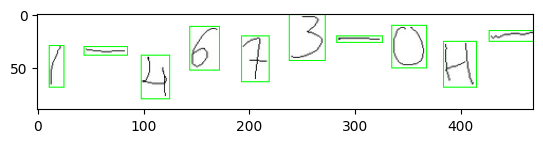

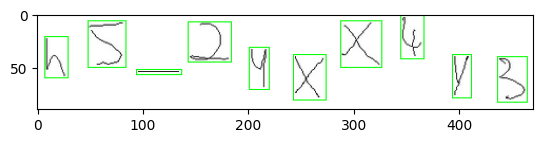

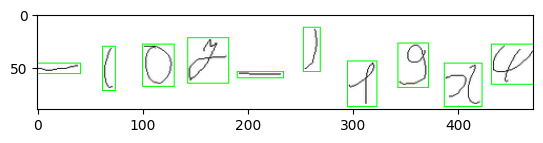

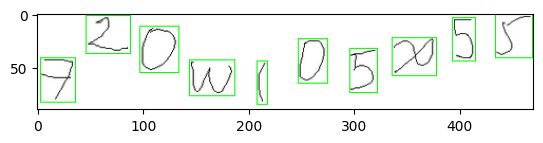

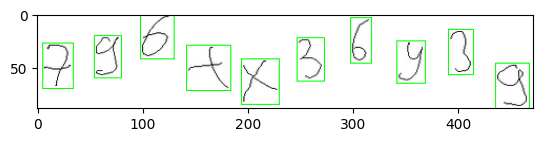

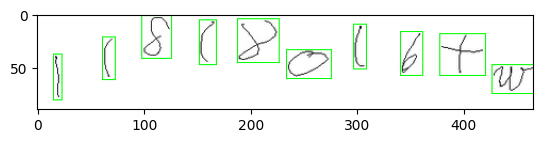

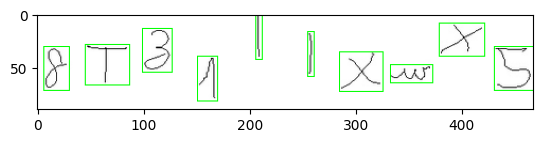

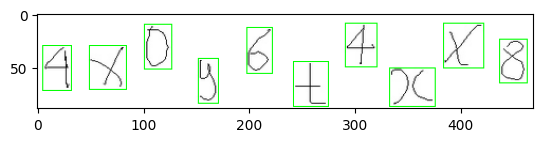

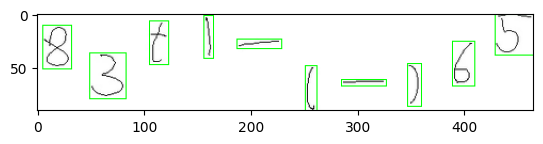

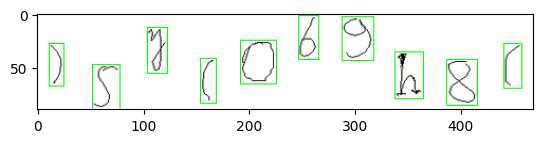

In [94]:
results = []
symb_vectors = []

for string, img_path in my_images_paths.items():
    symb_images = extract_symbols(img_path)
    if len(symb_images) == COUNT_NUMBERS_IN_STRINGS:
        predictions = knn_model.predict(symb_images)
        accuracy = accuracy_score(list(string), predictions)
        results.append((list(string), predictions, accuracy))
    else:
        print('На изображении неправильно определены контуры символов')

In [95]:
from pandas import DataFrame, concat

df_results = DataFrame(results, columns=['Символы исходной строки', 'Предсказанные символы', 'Accuracy'])
mean_accuracy = df_results['Accuracy'].mean()

new_row = DataFrame({
    'Символы исходной строки': [''],
    'Предсказанные символы': ['Средняя accuracy'],
    'Accuracy': [mean_accuracy]
})

df_result = concat([df_results, new_row], ignore_index=True)
df_result

,Символы исходной строки,Предсказанные символы,Accuracy
0,"[,, -, 4, 6, 7, 3, -, 0, h, -]","[(, -, 4, 6, 7, X, -, ), h, -]",0.7
1,"[h, 5, -, 2, y, X, *, 4, y, 3]","[h, 5, 1, 2, 1, X, *, +, y, 3]",0.7
2,"[-, (, 0, y, -, ,, 1, 9, X, 4]","[-, (, -, y, ), ), 1, 9, X, +]",0.6
3,"[7, 2, 0, w, (, 0, 5, X, 5, 5]","[y, 2, 0, w, (, 0, +, ,, ), )]",0.5
4,"[7, 9, 6, +, *, 3, 6, y, 3, 9]","[+, X, 0, +, ,, -, X, 1, 2, X]",0.1
5,"[1, (, 8, (, 8, 0, (, 6, +, w]","[1, 1, -, (, ), 0, (, (, +, +]",0.5
6,"[8, t, 3, 1, 1, 1, *, w, *, 5]","[8, t, -, 1, 1, 1, *, 1, 1, t]",0.6
7,"[4, *, 0, y, 6, t, 4, X, *, 8]","[+, -, 0, y, X, t, +, X, ,, 2]",0.4
8,"[8, 3, t, ,, -, (, -, ), 6, 5]","[8, -, +, 1, -, (, -, 1, 8, (]",0.4
9,"[), 5, y, (, 0, 6, 9, h, 8, (]","[-, 5, y, -, 0, X, -, 1, 8, (]",0.5


In [97]:
pip install editdistance

   ---------------------------------------- 0.0/79.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/79.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/79.9 kB ? eta -:--:--
   --------------- ------------------------ 30.7/79.9 kB 259.2 kB/s eta 0:00:01
   --------------- ------------------------ 30.7/79.9 kB 259.2 kB/s eta 0:00:01
   ------------------------------ --------- 61.4/79.9 kB 326.1 kB/s eta 0:00:01
   ---------------------------------------- 79.9/79.9 kB 370.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
import editdistance

def modify_and_calculate_cer(row):
    original = list(row['Символы исходной строки'])
    predicted = list(row['Предсказанные символы'])

    num_to_modify = random.randint(1, 3)
    indices = random.sample(range(len(predicted)), num_to_modify)
    predicted = [predicted[i] for i in range(len(predicted)) if i not in indices]
    predicted += random.choices(symbols, k=num_to_modify)
    
    cer = editdistance.eval(''.join(original), ''.join(predicted)) / max(len(original), len(predicted) or 1)
    return ''.join(original), ''.join(predicted), cer

In [99]:
df_results[['Символы исходной строки', 'Предсказанные символы', 'CER']] = df_results.apply(modify_and_calculate_cer, axis=1, result_type='expand')

mean_cer = df_results['CER'].mean()

new_row = DataFrame({
    'Символы исходной строки': [''],
    'Предсказанные символы': ['Среднее значение'],
    'CER': [mean_cer]
})

df_сer = concat([df_results, new_row], ignore_index=True).drop(columns=['Accuracy'])
df_сer

,Символы исходной строки,Предсказанные символы,CER
0,",-4673-0h-","(467X-)h-,",0.50
1,h5-2yX*4y3,h5121*+y34,0.50
2,"-(0y-,19X4",(-y)19X+y3,0.70
3,720w(05X55,"y2w(0+,))-",0.70
4,796+*36y39,"X0+,-XX)t3",1.00
5,1(8(80(6+w,1-()((+7tt,0.80
6,8t3111*w*5,8t111*11t4,0.50
7,4*0y6t4X*8,+-0yX+X252,0.80
8,"83t,-(-)65",8-+1--18(5,0.70
9,)5y(069h8(,-5y0X-18(w,0.60
